## E13. DCGAN with CIFAR-10 
DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 보기. 

### Executive Summary 
* 처음엔 아이펠 노드에 있는 generator와 discriminator 모델을 가져와서 훈련하고 이미지를 생성했다. 훈련후 생성 이미지는 무엇인지 알아볼 수가 없었다. 
* 다음과 같이 모델과 학습에 변화를 주어 모델을 훈련했다. 그 결과, 이미지에 색상이 더 다양하게 입혀졌지만 여전히 이미지의 퀄리티는 아쉽다. 
    * discriminator의 layer를 한층 깊게 쌓았다. 
    * discriminator의 dropout rate을 0.3에서 0.5로 조정해주었다. 
    * discriminator의 learning rate을 0.0001에서 0.0002로 상향 조정해 주었다. 
    * generator와 discriminator의 loss를 label smoothing으로 조정해주어서 과도한 extrapolation을 방지해주었다. 
* 다음에 시도해 볼 수 있는점 
    * epoch를 현재 50에서 300 혹은 그 이상으로 올려서 훈련해 보기 (최소 3 시간 이상 걸린다.)  
    * discriminator의 마지막 layer의 activation function을 sigmoid로 추가해 보기 
    * loss를 label smoothing말고 다른 방식으로 접근할 수 있는지 고민해 보기. 혹은 accuracy의 평가기준을 다시 고려해보기.  
    * 참고할만한 사이트 
    https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
    https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

### 필요한 모듈 가져오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 데이터 가져오기
* 5만개의 이미지가 있다. 32/32에 color이미지인것을 확인할 수 있다. 
* 학습 데이터를 시각화해 보기
* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화했다. 
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 데이터를 shuffle 해주고 batch_size에 따라서 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10
(train_x,_), (test_x,_) = cifar10.load_data()
train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

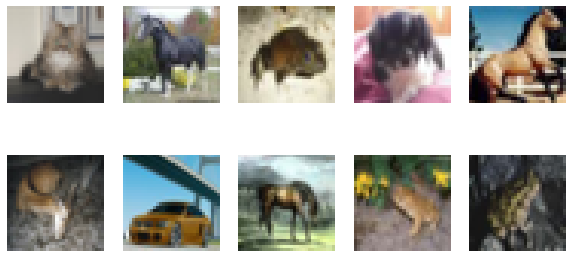

In [3]:
# 이미지 시각화 
plt.figure(figsize=(10,5))

for i in range(10): 
    plt.subplot(2, 5, i+1)
    img_ind = np.random.randint(1,50000)
    plt.imshow(train_x[img_ind])
    plt.axis('off')
plt.show()

In [4]:
# min=0, max=255
train_x.max(), train_x.min()

(255, 0)

In [5]:
# 이미지 정규화 (-1,1 사이)
train_x = (train_x - 127.5) / 127.5

In [6]:
# tensor shuffle 
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### DCGAN, Generator 모델 
* 사용한 모델: DCGAN
    * DCGAN(Deep Convolutional Generative Adversarial Nets): GAN이 나온 1년반 이후에 논문으로 발표되었다. 이전의 GAN을 발전시켜, 고화질 이미지를 생성한다. 
    * DCGAN은 generator와 discriminator 두 모델로 이루어져 있다. 
    * Generator는 의미없는 랜덤 노이즈를 신경망에 통과해 이미지 벡터를 생성해 낸다.    무에서 유를 창조.     
    * Discriminator는 기존에 있던 진짜 이미지와 generator가 만들어낸 가짜 이미지를 검토해서 진짜인지 가짜인지를 실수값으로 출력한다.       

* Generator 모델
    * INPUT: (Batch_size, 100) 모양의 noise 벡터 
    * Dense, Conv2DTranspose layer를 통해서 output의 값을 (8,8)에서 (16,16)로 (32, 32)로 바꿔준다. 
    * 마지막 output layer는 Conv2D를 이용해서 (32,32,3) 의 real image와 같은 형태로 만들어준다.  
    * Dense output:8\*8\*256 
    * BatchNorm: 정규화과정을 모든 layer에 넣어준다. 
    * kernel size = (4, 4) 
    * Non-linear function: LeakyReLU를 사용하고 마지막 layer에만 tanh 함수를 사용해서 train_x에서 정규화 해주었던 데이터와(-1에서 1사이의 값) 대등하게 해준다.

#### generator model 함수

In [7]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    # First: Dense/BatchNorm/LeakyReLU 
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: reshape
    model.add(layers.Reshape((8, 8, 256)))
    
    # Thrid: Conv2DTranspose/BatchNorm/LeakyReLU
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose/BatchNorm/LeakyReLU (output=(16, 16))
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose/BatchNorm/LeakyReLU (output=(32, 32))
    model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Sixth: Output
    model.add(layers.Conv2D(3, (3,3), padding='same', activation='tanh'))
    
    return model 

In [8]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

#### noise 만들기

In [9]:
noise = tf.random.normal([1, 100])

#### generator로 가짜 이미지 한개 샘플로 만들어보기

In [10]:
# generator = generator model 
# noise = input 
generated_images = generator(noise, training=False)
generated_images.shape

TensorShape([1, 32, 32, 3])

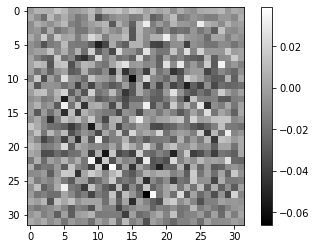

In [11]:
plt.imshow(generated_images[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### Discriminator 모델 만들기
* Input shape=(32, 32, 3): generator를 통해 만들어진 이미지와 실제 이미지의 규격 
* Conv2D: stride를 2로 해줘서 크기가 절반으로 계속 줄어든다. output크기는 (32, 32)에서 (16, 16)으로 (8,8)로 줄어든다. 
* kernel size = generator 모델과 동일하게 (4,4)로 설정. 
* Dropout: overfitting 방지를 위해 추가 
* nonlinear 함수: generator 모델과 동일하게 LeakyReLU 함수 사용. 

In [12]:
def make_discriminator_model():

    model = tf.keras.Sequential()

    # First: Conv2D/LeakyReLU/Dropout (output=(16, 16))
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D/LeakyReLU/Dropout (output=(8, 8))
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [13]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### loss 함수 만들기
* 실제값은 1이고 fake값은 0.     
* Binarycrossentropy: 기본적으로 인풋값이 0-1 사이에 분포하는 확률값이라고 가정한다. 따라서 from_logits를 True로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.      
* generator       
    * cross_entropy(true, pred) : Computes the cross-entropy loss between true labels and predicted labels.   
    * cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (실제 이미지를 의미하는) 1에 가까울수록 작은 값을 가집니다. 
    * 모델은 loss 값을 최소화 하기위해 훈련 할 것이다. 즉, fake_out이 실제 이미지를 닮기 위해 노력할 것이다.  
    
* discriminator           
    * real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교한다.
    * discriminator는 실제 이미지와 가짜 이미지를 최대한 잘 판별하기 위해 loss 값을 이용한다. 
    * real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산해야 한다. 
    

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
# generator
def generator_loss(fake_output): 
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# discriminator 
def discriminator_loss(real_output, fake_output): 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### accuracy metrics
1. tf.math.greater_equal(real_output, tf.constant(0.5) : real_output의 각 원소가 0.5 이상인지 True, False로 판별 - >> tf.Tensor([False, False, True, True])     
2. tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환 - >> tf.Tensor([0.0, 0.0, 1.0, 1.0])    
3. tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산 - >> 0.5      

In [17]:
def discriminator_accuracy(real_output, fake_output): 
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### optimizer
* make two optimizers, one for generator and one for discriminator 
* learning rate = 0.0001

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### sample 만들어주기 

In [19]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### 훈련 과정 설계 
* train_step 함수 만들기
    1. 입력데이터: 실제 이미지 세트
    2. 생성자 입력 노이즈 : generator가 가짜 이미지를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
        * noise dimension = 100
        * batch size = 256 
    3. tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
    4. generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
    5. discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
    6. loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
    7. accuracy 계산 : fake_output, real_output으로 discriminator가
    8. gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
    9. 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    10. 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴
* 시각화: 매 epoch마다 gen_loss, disc_loss, real_accuracy, fake_accuracy를 시각화 해 준다. 
* checkpoint 추가 

In [20]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [21]:
# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [22]:
# checkpoint
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 모델 훈련 

In [24]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [25]:
save_every = 5
EPOCHS = 50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

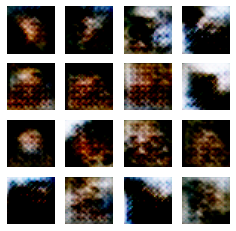

Time for training : 1398 sec


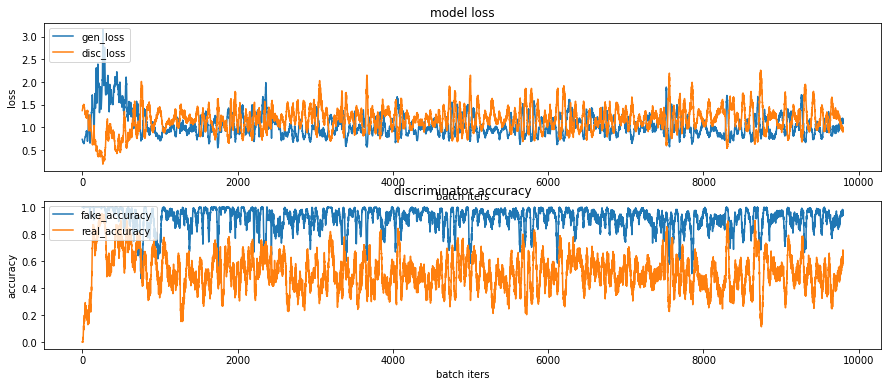

CPU times: user 23min 10s, sys: 34 s, total: 23min 44s
Wall time: 23min 19s


In [26]:
%%time
train(train_dataset, EPOCHS, save_every)

In [27]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1111262 Sep  2 02:40 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


### 평가 
* 생성된 이미지가 점점 향상되기는 하지만 실제 CIFAR10 이미지와 비슷하지는 않다.

### 새로운 시도 
다음과 같은것을 바꿔보았다. 
* generator: 그대로 유지 
* discriminator를 다음과 같이 바꿔주었다. 
    * dropout = 0.5
    * Third: add one more Conv2D/LeakyReLU/Dropout layers with more filters. 

In [29]:
def make_discriminator_model2():

    model = tf.keras.Sequential()

    # First: Conv2D/LeakyReLU/Dropout (output=(16, 16))
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D/LeakyReLU/Dropout (output=(8, 8))
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Third: Conv2D/LeakyReLU/Dropout (output=(4, 4))
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [30]:
discriminator2 = make_discriminator_model2()
discriminator2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)        

#### loss 함수,  accuracy metrics  
* label_smoothing: 0.1      
When 0, no smoothing occurs. When > 0, we compute the loss between the predicted labels and a smoothed version of the true labels, where the smoothing squeezes the labels towards 0.5. Larger values of label_smoothing correspond to heavier smoothing. (출처: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) 

In [31]:
cross_entropy_sm = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)

In [32]:
# generator
def generator_loss_sm(fake_output): 
    return cross_entropy_sm(tf.ones_like(fake_output), fake_output)

In [33]:
# discriminator 
def discriminator_loss_sm(real_output, fake_output): 
    real_loss = cross_entropy_sm(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_sm(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#### optimizer 
* discriminator, learning rate = 1e-4*2

In [34]:
discriminator_optimizer2 = tf.keras.optimizers.Adam(1e-4*2)

#### 모델 설계 

In [35]:
@tf.function
def train_step2(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator2(images, training=True)
        fake_output = discriminator2(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss_sm(fake_output)
        disc_loss = discriminator_loss_sm(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer2.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [36]:
# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history2(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history_version2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [37]:
# checkpoint
checkpoint_dir2 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints_version2'

checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt")
checkpoint2 = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer2,
                                 generator=generator,
                                 discriminator=discriminator2)

In [38]:
def generate_and_save_images2(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(6, 6)) # changed from 4 to 6
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples_version2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [39]:
def train2(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step2(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images2(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix2)

        display.clear_output(wait=True)
        generate_and_save_images2(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history2(history, epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

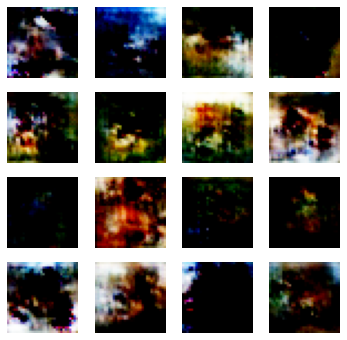

Time for training : 1962 sec


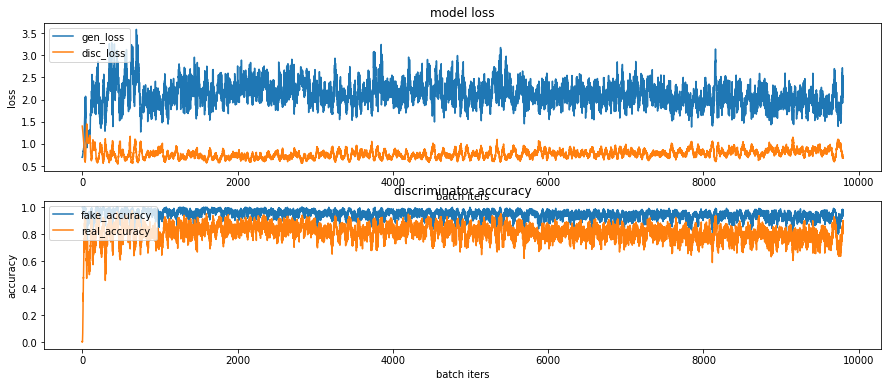

CPU times: user 32min 35s, sys: 26.2 s, total: 33min 1s
Wall time: 32min 43s


In [40]:
%%time
train2(train_dataset, EPOCHS, save_every)

In [41]:
anim_file2 = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_version2.gif'

with imageio.get_writer(anim_file2, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples_version2/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_version2.gif

-rw-r--r-- 1 root root 2217719 Sep  2 05:55 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_version2.gif
